# Ex 1

In [ ]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

For most GP regression models, you will need to construct the following GPyTorch objects:

1. A GP Model (gpytorch.models.ExactGP) - This handles most of the inference.

2. A Likelihood (gpytorch.likelihoods.GaussianLikelihood) - This is the most common likelihood used for GP regression.

3. A Mean - This defines the prior mean of the GP.(If you don’t know which mean to use, a gpytorch.means.ConstantMean() is a good place to start.)

4. A Kernel - This defines the prior covariance of the GP.(If you don’t know which kernel to use, a gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) is a good place to start).

5. A MultivariateNormal Distribution (gpytorch.distributions.MultivariateNormal) - This is the object used to represent multivariate normal distributions.



## Ex 2

In [2]:
%set_env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [3]:
import torch
import tqdm
from tqdm import notebook
import gpytorch
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.distributions import MultivariateNormal
from gpytorch.models import ApproximateGP, GP
from gpytorch.mlls import VariationalELBO, AddedLossTerm
from gpytorch.likelihoods import GaussianLikelihood

In [4]:
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.mlls import DeepApproximateMLL

In [5]:
import urllib.request
import os
from scipy.io import loadmat
from math import floor

In [6]:
import numpy as np
data = torch.tensor(np.genfromtxt('elevators.csv', delimiter = ','))

In [ ]:
# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)

In [ ]:
if smoke_test:  # this is for running the notebook in our testing framework
    X, y = torch.randn(1000, 3), torch.randn(1000)
else:
    data = torch.Tensor(np.genfromtxt('elevators.csv', delimiter = ','))
    X = data[:, :-1]
    X = X - X.min(0)[0]
    X = 2 * (X / X.max(0)[0]) - 1
    y = data[:, -1]

In [ ]:
train_n = int(floor(0.8 * len(X)))
train_x = X[:train_n, :].contiguous()
train_y = y[:train_n].contiguous()

test_x = X[train_n:, :].contiguous()
test_y = y[train_n:].contiguous()

if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

In [ ]:
class ToyDeepGPHiddenLayer(DeepGPLayer):
    def __init__(self, input_dims, output_dims, num_inducing=128, mean_type='constant'):
        if output_dims is None:
            inducing_points = torch.randn(num_inducing, input_dims)
            batch_shape = torch.Size([])
        else:
            inducing_points = torch.randn(output_dims, num_inducing, input_dims)
            batch_shape = torch.Size([output_dims])

        variational_distribution = CholeskyVariationalDistribution(
            num_inducing_points=num_inducing,
            batch_shape=batch_shape
        )

        variational_strategy = VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True
        )

        super(ToyDeepGPHiddenLayer, self).__init__(variational_strategy, input_dims, output_dims)

        if mean_type == 'constant':
            self.mean_module = ConstantMean(batch_shape=batch_shape)
        else:
            self.mean_module = LinearMean(input_dims)
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=batch_shape, ard_num_dims=input_dims),
            batch_shape=batch_shape, ard_num_dims=None
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

    def __call__(self, x, *other_inputs, **kwargs):
        """
        Overriding __call__ isn't strictly necessary, but it lets us add concatenation based skip connections
        easily. For example, hidden_layer2(hidden_layer1_outputs, inputs) will pass the concatenation of the first
        hidden layer's outputs and the input data to hidden_layer2.
        """
        if len(other_inputs):
            if isinstance(x, gpytorch.distributions.MultitaskMultivariateNormal):
                x = x.rsample()

            processed_inputs = [
                inp.unsqueeze(0).expand(gpytorch.settings.num_likelihood_samples.value(), *inp.shape)
                for inp in other_inputs
            ]

            x = torch.cat([x] + processed_inputs, dim=-1)

        return super().__call__(x, are_samples=bool(len(other_inputs)))

In [ ]:
num_hidden_dims = 2 if smoke_test else 10


class DeepGP(DeepGP):
    def __init__(self, train_x_shape):
        hidden_layer = ToyDeepGPHiddenLayer(
            input_dims=train_x_shape[-1],
            output_dims=num_hidden_dims,
            mean_type='linear',
        )

        last_layer = ToyDeepGPHiddenLayer(
            input_dims=hidden_layer.output_dims,
            output_dims=None,
            mean_type='constant',
        )

        super().__init__()

        self.hidden_layer = hidden_layer
        self.last_layer = last_layer
        self.likelihood = GaussianLikelihood()

    def forward(self, inputs):
        hidden_rep1 = self.hidden_layer(inputs)
        output = self.last_layer(hidden_rep1)
        return output

    def predict(self, test_loader):
        with torch.no_grad():
            mus = []
            variances = []
            lls = []
            for x_batch, y_batch in test_loader:
                preds = self.likelihood(self(x_batch))
                mus.append(preds.mean)
                variances.append(preds.variance)
                lls.append(model.likelihood.log_marginal(y_batch, model(x_batch)))

        return torch.cat(mus, dim=-1), torch.cat(variances, dim=-1), torch.cat(lls, dim=-1)

In [ ]:
model = DeepGP(train_x.shape)
if torch.cuda.is_available():
    model = model.cuda()

In [ ]:
# this is for running the notebook in our testing framework
num_epochs = 1 if smoke_test else 10
num_samples = 3 if smoke_test else 10

epoch_list = []
loss_list = []

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=0.01)
mll = DeepApproximateMLL(VariationalELBO(model.likelihood, model, train_x.shape[-2]))

epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    epoch_list.append(i)
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch in minibatch_iter:
        with gpytorch.settings.num_likelihood_samples(num_samples):
            optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch)
            loss.backward()
            optimizer.step()
            
            minibatch_iter.set_postfix(loss=loss.item())
            loss = float(loss)
            loss_list.append(loss)

In [ ]:
epoch_list

In [ ]:
loss_list

In [ ]:
import gpytorch
import math


test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=1024)

model.eval()
predictive_means, predictive_variances, test_lls = model.predict(test_loader)

rmse = torch.mean(torch.pow(predictive_means.mean(0) - test_y, 2)).sqrt()
print(f"RMSE: {rmse.item()}, NLL: {-test_lls.mean().item()}")

In [ ]:
import matplotlib.pyplot as plt
import numpy



plt.plot(loss_list)

## EX 3

In [15]:
import math
from matplotlib import pyplot as plt

In [11]:
# Training data is 100 points in [0,1] inclusive regularly spaced
x_train = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
y_train = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

In [18]:
x_train.shape

torch.Size([100])

In [12]:
class SpectralMixtureGP(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood):
        super(SpectralMixtureGP, self).__init__(x_train, y_train, likelihood)
        self.mean = gpytorch.means.ConstantMean() # Construct the mean function
        self.cov = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4) # Construct the kernel function
        self.cov.initialize_from_data(x_train, y_train) # Initialize the hyperparameters from data
        
    def forward(self, x):
        # Evaluate the mean and kernel function at x
        mean_x = self.mean(x)
        cov_x = self.cov(x)
        # Return the multivariate normal distribution using the evaluated mean and kernel function
        return gpytorch.distributions.MultivariateNormal(mean_x, cov_x) 
        
# Initialize the likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SpectralMixtureGP(x_train, y_train, likelihood)

In [13]:

# Put the model into training mode
model.train()
likelihood.train()

# Use the Adam optimizer, with learning rate set to 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Use the negative marginal log-likelihood as the loss function
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Set the number of training iterations
n_iter = 50

for i in range(n_iter):
    # Set the gradients from previous iteration to zero
    optimizer.zero_grad()
    # Output from model
    output = model(x_train)
    # Compute loss and backprop gradients
    loss = -mll(output, y_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 1.330
Iter 2/50 - Loss: 1.311
Iter 3/50 - Loss: 1.283
Iter 4/50 - Loss: 1.262
Iter 5/50 - Loss: 1.244
Iter 6/50 - Loss: 1.224
Iter 7/50 - Loss: 1.206
Iter 8/50 - Loss: 1.190
Iter 9/50 - Loss: 1.176
Iter 10/50 - Loss: 1.161
Iter 11/50 - Loss: 1.142
Iter 12/50 - Loss: 1.121
Iter 13/50 - Loss: 1.099
Iter 14/50 - Loss: 1.074
Iter 15/50 - Loss: 1.046
Iter 16/50 - Loss: 1.015
Iter 17/50 - Loss: 0.981
Iter 18/50 - Loss: 0.945
Iter 19/50 - Loss: 0.908
Iter 20/50 - Loss: 0.871
Iter 21/50 - Loss: 0.834
Iter 22/50 - Loss: 0.798
Iter 23/50 - Loss: 0.764
Iter 24/50 - Loss: 0.733
Iter 25/50 - Loss: 0.704
Iter 26/50 - Loss: 0.678
Iter 27/50 - Loss: 0.655
Iter 28/50 - Loss: 0.634
Iter 29/50 - Loss: 0.615
Iter 30/50 - Loss: 0.598
Iter 31/50 - Loss: 0.583
Iter 32/50 - Loss: 0.570
Iter 33/50 - Loss: 0.558
Iter 34/50 - Loss: 0.548
Iter 35/50 - Loss: 0.539
Iter 36/50 - Loss: 0.532
Iter 37/50 - Loss: 0.526
Iter 38/50 - Loss: 0.521
Iter 39/50 - Loss: 0.517
Iter 40/50 - Loss: 0.514
Iter 41/5

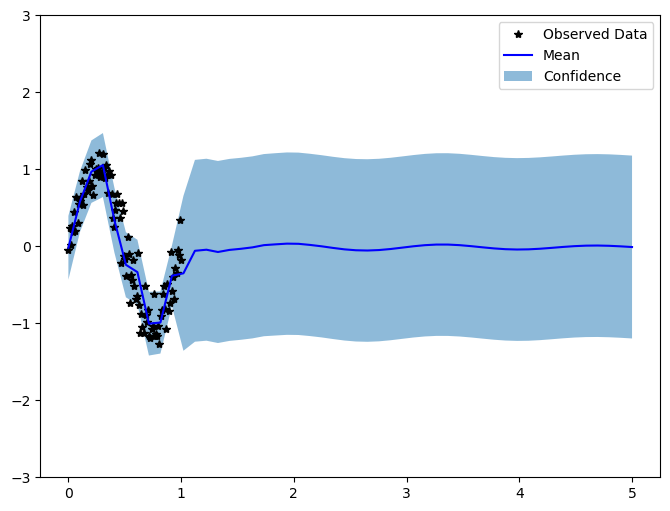

In [16]:
# The test data is 50 equally-spaced points from [0,5]
x_test = torch.linspace(0, 5, 50)

# Put the model into evaluation mode
model.eval()
likelihood.eval()

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Obtain the predictive mean and covariance matrix
    f_preds = model(x_test)
    f_mean = f_preds.mean
    f_cov = f_preds.covariance_matrix
    
    # Make predictions by feeding model through likelihood
    observed_pred = likelihood(model(x_test))
    
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(x_train.numpy(), y_train.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(x_test.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(x_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

test change